In [6]:
# First import necessary library
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy import stats
from scipy.stats import norm, skew
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score,train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline #make_pipeline
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV
from sklearn import svm
from lightgbm import LGBMRegressor


In [7]:
# # Dataset details
Airline_df =  pd.read_csv('airline.csv')

In [8]:
# Datatype details
Airline_df.dtypes

SL. No.           int64
Class             int64
Age             float64
time              int64
adv_bookdays      int64
weekday           int64
month             int64
monthday          int64
demand            int64
from_ind          int64
to_ind            int64
Fare            float64
dtype: object

In [9]:
#  Statistical description of Data. # Notice that in SL.No count is 6000 but the max is showing as 7500. This could be because 
# some rows could have been completely removed.
Airline_df.describe()

,SL. No.,Class,Age,time,adv_bookdays,weekday,month,monthday,demand,from_ind,to_ind,Fare
count,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000,4999.000000
mean,3103.027005,0.257051,48.478436,37.325465,23.414283,3.035207,4.331266,15.372474,1.267654,3.606721,3.985997,8525.626751
std,1816.650469,0.437052,18.635317,5.992250,15.141569,2.006582,2.817279,8.862410,0.538230,1.990615,2.043300,6521.815943
min,1.000000,0.000000,12.800000,24.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1132.820000
25%,1507.500000,0.000000,33.900000,33.000000,12.000000,1.000000,2.000000,8.000000,1.000000,2.000000,2.000000,4359.290000
50%,3067.000000,0.000000,48.100000,38.000000,21.000000,3.000000,4.000000,15.000000,1.000000,3.000000,4.000000,6626.410000
75%,4679.500000,1.000000,64.100000,42.000000,33.000000,5.000000,7.000000,23.000000,1.000000,5.000000,6.000000,10546.235000
max,6234.000000,1.000000,83.700000,48.000000,95.000000,6.000000,11.000000,31.000000,5.000000,7.000000,7.000000,84141.470000


In [10]:
#Splitting of Data into training and testing subset abd creating a "label" Column, in this case 'Fare'
df_train = Airline_df[0:5999]
df_test = Airline_df[5999:]
df_test = df_test.drop(['Fare'], axis =1)

In [11]:
X = df_train.drop(['Fare'], axis=1)
y = df_train.Fare

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Linear regression

In [13]:
#Build our model method
lm = LinearRegression()

In [14]:
#Build our cross validation method. Cross Validation ensures that sample data is taken is taken from randomly]
# selected subsample, which avoids bias problems
kfolds = KFold(n_splits=50,shuffle=True, random_state=100)

In [15]:
# Define Root means square error value, which is used to measure accuracy of model.
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X, y, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

In [16]:
# Pipeline is a tool in python to more than one function at time to make computation easier and elegant
# Here we are pipelining two function a "Scaler" and Linear regression. RobustScaler Scale features using statistics
#that are robust to outliers.Root means Square Error is one of the indicator of accuracy of Model

pipeline1 = Pipeline(steps=[('RobustScaler',RobustScaler()), ('lm',lm) ])
benchmark_model = pipeline1.fit(X=X_train,y = y_train)
linear_model = pipeline1.steps[1][1]
print(linear_model)
cv_rmse(benchmark_model).mean()


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


4770.384513700063

Ridge Regression

In [17]:
# Ridge regression is a way to create a parsimonious model when the number of predictor variables ( independant variables)
#in a set exceeds the number of observations, or when a data set has multicollinearity (correlations between predictor variables)
# Ridge regression is a higher order regression which performs regularization ( compensates for bias in Data)
# Bias is a case when a model does too well in training data but not in testing data. Penalty for bias is of "square" order
from sklearn.linear_model import RidgeCV

In [18]:
# Define a fucntion which will select various optization parameter Alpha, fit model with that Alpha and
# calculate RMSE according to that Alpha
def ridge_selector(k):
   
    pipeline2 = Pipeline(steps=[('RobustScaler',RobustScaler()), ('Ridgecv',RidgeCV(alphas = [k],cv=kfolds)) ])
    ridge_model = pipeline2.fit(X_train,y_train)
    ridge_rmse = cv_rmse(ridge_model).mean()
    ridgemodel = pipeline2.steps[1][1]
    #print(ridgemodel)
    return(ridge_rmse)


In [19]:
# Alpha adds a factor of sum of squares of coefficients in the optimization/Regularization objective. 
# It is equal to adding some weights to coeffecients in a model equiavelent to Y(hat) = alpha1*X1+aplpha2*X2+aplha3*X3..
r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 20, 30, 50, 60, 70, 80]


In [20]:
# Score accuracy the model according various Alphas
ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)

Text(0,0.5,'score')

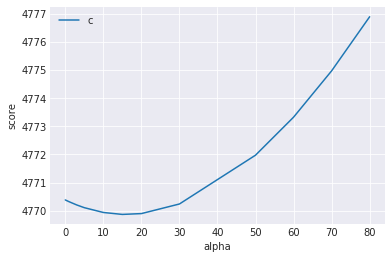

In [21]:
# Plot the scores (accuracy) of Ridge Regeression. Notice that as value of Alpha increases the accuracy of model(RMSE) first dips
# and then increases
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

In [22]:
# Tabulate the scores of Ridge Regression
ridge_score_table = pd.DataFrame(ridge_scores, r_alphas, columns=['RMSE'])
ridge_score_table

,RMSE
0.0001,4770.384507
0.0003,4770.384494
0.0005,4770.384481
0.0007,4770.384468
0.0009,4770.384455
0.0100,4770.383856
0.0500,4770.381231
0.1000,4770.377959
0.3000,4770.364978
1.0000,4770.320905


In [23]:
# Now for the same model, choose a different set of alphas and fit the model again
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]

pipeline3 = Pipeline(steps=[('RobustScaler',RobustScaler()), ('Ridgecv',RidgeCV(alphas = alphas_alt,cv=kfolds)) ])
ridge_model2 = pipeline3.fit(X_train,y_train)
ridgemodel2 = pipeline3.steps[1][1] # pulls out the coefficients out of the fitted model
cv_rmse(ridge_model2).mean() # Calculate the average of all RMSEs

4769.868096562193

Lasso Regression

In [24]:
# Lasso regression (Least Absolute Shrinkage and Selection Operator).Performs L1 regularization, i.e. adds penalty
#equivalent to absolute value of the magnitude of coefficients
alphas = [0.00005, 0.0001, 0.0003, 0.0005, 0.0007, 
          0.0009, 0.01]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
           0.0006, 0.0007, 0.0008]


In [25]:
pipeline4 = Pipeline(steps=[('RobustScaler',RobustScaler()), ('Ridgecv',LassoCV(max_iter=1e7,alphas = alphas2,random_state = 42)) ])
lasso_model2 = pipeline4.fit(X_train,y_train)
lassomodel2 = pipeline4.steps[1][1]

In [26]:
scores = pipeline4.steps[1][1].mse_path_


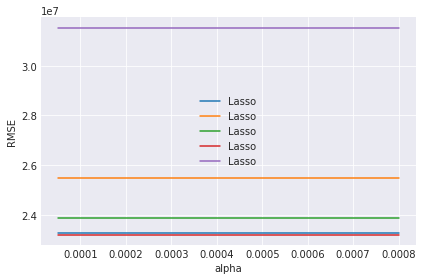

In [27]:
plt.plot(alphas2, scores, label='Lasso')
plt.legend(loc='center')
plt.xlabel('alpha')
plt.ylabel('RMSE')
plt.tight_layout()
plt.show()

In [28]:
# Calculate the accuracy measure of Lasso Model
cv_rmse(lasso_model2).mean()

4770.384447742687

Elastic Net Regression

In [30]:
from sklearn.pipeline import make_pipeline
#elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods.
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

elastic_cv = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

elastic_model3 = elastic_cv.fit(X_train, y_train)
elasticmodel = elastic_model3.steps[1][1]
print(elasticmodel)

ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
             copy_X=True, cv=KFold(n_splits=50, random_state=100, shuffle=True),
             eps=0.001, fit_intercept=True,
             l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1], max_iter=10000000.0,
             n_alphas=100, n_jobs=None, normalize=False, positive=False,
             precompute='auto', random_state=None, selection='cyclic',
             tol=0.0001, verbose=0)


In [31]:
cv_rmse(elastic_model3).mean()

4770.340265544186

XGBoost 

In [33]:
#XGBoost is an algorithm that has recently been dominating applied machine learning  for structured or tabular data. 
#XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
from sklearn.model_selection import GridSearchCV
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
get_ipython().run_line_magic('matplotlib', 'inline')
import xgboost as xgb
from xgboost import XGBRegressor

In [34]:
xgb3 = XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,max_bin=20,
                     colsample_bytree=0.8,objective= 'reg:squarederror',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006)

xgb_fit = xgb3.fit(X_train, y_train)


In [35]:
cv_rmse(xgb_fit).mean()

3000.027906666564

Support vector machine

In [36]:
#Support Vector Machine(SVM, a classification algorithm) algorithm to predict a continuous variable. While other linear regression models try to minimize the error between the predicted and the actual value, 
#Support Vector Regression tries to fit the best line within a predefined or threshold error value.
from sklearn import svm
svr_opt = svm.SVR(C = 100000, gamma = 1e-08)

svr_fit = svr_opt.fit(X_train, y_train)


In [37]:
cv_rmse(svr_fit).mean()

6551.767445859537

Light GBM 

In [38]:
#LightGBM is a gradient boosting framework that uses tree based learning algorithms. 
#It is designed to be distributed and efficient with the following advantages: 
#Support of parallel and GPU learning. Capable of handling large-scale data.
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =20, min_sum_hessian_in_leaf = 11)
lgbm_fit = lgbm_model.fit(X_train, y_train)


In [39]:
cv_rmse(lgbm_fit).mean()

2753.7164886901714

In [40]:
# get feature importances from a model.Feature impirtance is an important technique in Data science, which
# allows only important features from data to be used in a model, to avoid lot of bias and variance issues which comes up
# later.
import matplotlib.pyplot as plt
def plotFeatureImportances(model):
    #first print all features importances in descending order
    feature_importances = pd.DataFrame(model.coef_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
    print(feature_importances)
    # Next plot feature importances to get idea about where the curve breaks
    # in the graph i.e. select top appropriate features
    features = X.columns.tolist()
    importances = model.coef_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

In [41]:
# the below function can be used to generate excel file for a given model which can then be submitted

def generateFinalPredictionFile(model):
    y_test_pred = model.predict(X_to_predict.values)
    y_test_pred_exp = np.exp(y_test_pred)
    print(y_test_pred_exp)
    pd.DataFrame(y_test_pred_exp, columns = ['Price']).to_excel("Final_Pred.xlsx", index = False)

               importance
Class         9482.958046
to_ind        1150.424192
Age           1012.863231
from_ind       834.523201
time           166.234289
month          115.245769
weekday         -5.802976
monthday      -223.451226
demand        -535.865981
SL. No.      -1498.696290
adv_bookdays -2093.954528


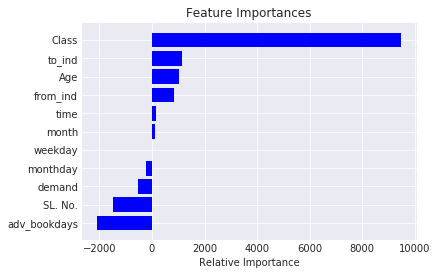

In [42]:
plotFeatureImportances(elasticmodel)

               importance
Class         9489.904086
to_ind        1151.767358
Age           1013.052225
from_ind       834.927804
time           166.272988
month          115.459801
weekday         -5.811217
monthday      -223.620108
demand        -535.879050
SL. No.      -1499.915114
adv_bookdays -2094.692612


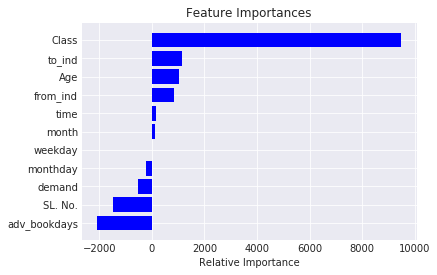

In [43]:
plotFeatureImportances(linear_model)

               importance
Class         9275.050507
to_ind        1110.687894
Age           1007.050518
from_ind       822.428468
time           165.077088
month          108.942394
weekday         -5.619926
monthday      -218.428078
demand        -535.295891
SL. No.      -1462.479053
adv_bookdays -2071.654763


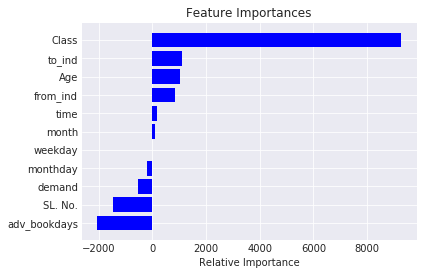

In [44]:
plotFeatureImportances(ridgemodel2)

               importance
Class         9489.899899
to_ind        1151.761650
Age           1013.050083
from_ind       834.925601
time           166.271220
month          115.457182
weekday         -5.808171
monthday      -223.617787
demand        -535.876613
SL. No.      -1499.910449
adv_bookdays -2094.690381


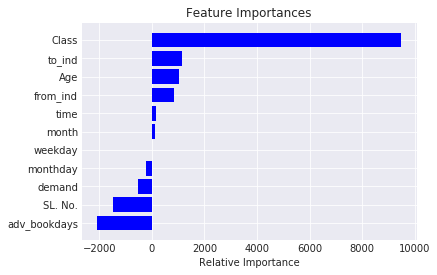

In [45]:
plotFeatureImportances(lassomodel2)

count     4999.000000
mean      8525.626751
std       6521.815943
min       1132.820000
25%       4359.290000
50%       6626.410000
75%      10546.235000
max      84141.470000
Name: Fare, dtype: float64
Skewness: 2.683233
Kurtosis: 12.732976


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


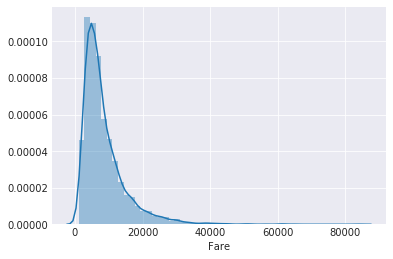

In [46]:
#Source:- https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
#descriptive statistics summary
import seaborn as sns
print(Airline_df['Fare'].describe())
#skewness and kurtosis
print("Skewness: %f" % Airline_df['Fare'].skew())
print("Kurtosis: %f" % Airline_df['Fare'].kurt())
sns.distplot(Airline_df['Fare'])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


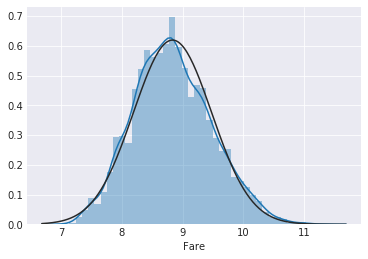

In [47]:
from scipy.stats import norm, skew 
sns.distplot(np.log1p(Airline_df["Fare"]) , fit=norm);

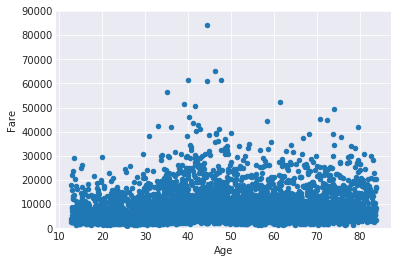

In [48]:
#scatter plot Duration_minutes/Price
var = 'Age'
data = pd.concat([Airline_df['Fare'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='Fare', ylim=(0,90000));

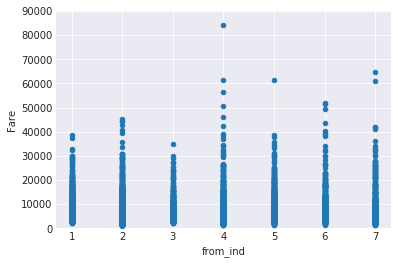

In [49]:
var = 'from_ind'
data = pd.concat([Airline_df['Fare'], Airline_df[var]], axis=1)
data.plot.scatter(x=var, y='Fare', ylim=(0,90000));

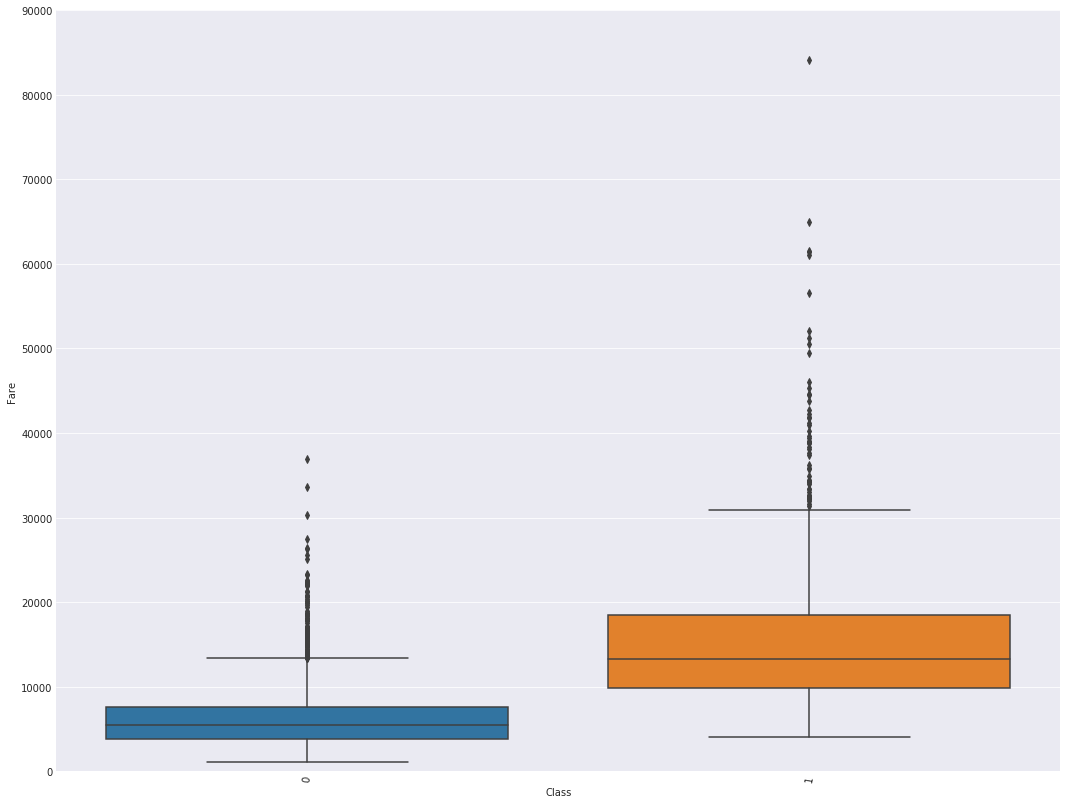

In [50]:
#box plot Airline/Price
var = 'Class'
data = pd.concat([Airline_df['Fare'], Airline_df[var]], axis=1)
f, ax = plt.subplots(figsize=(18, 14))
fig = sns.boxplot(x=var, y="Fare", data=data)
plt.xticks(fontsize=10, rotation=80)
fig.axis(ymin=0, ymax=90000);

Text(0.5,1,'From India')

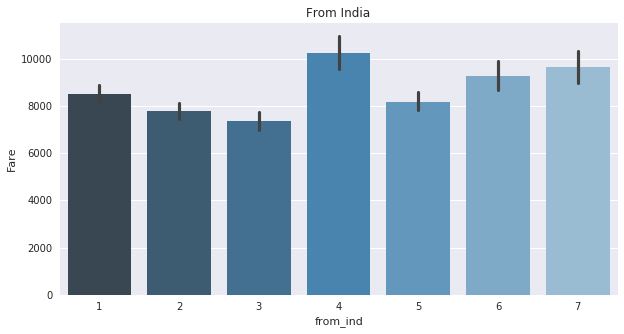

In [51]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="from_ind", y="Fare", data=Airline_df, palette="Blues_d")
plt.title('From India')

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000.]), <a list of 9 Text yticklabel objects>)

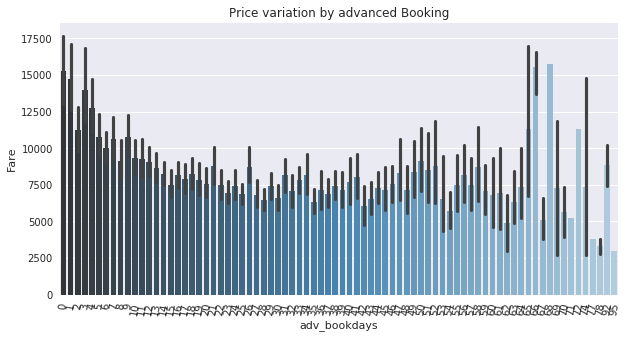

In [52]:
sns.set(style="darkgrid")
figure(figsize=(10,5)) 
sns.barplot(x="adv_bookdays", y="Fare", data=Airline_df, palette="Blues_d")
plt.title('Price variation by advanced Booking')
plt.xticks(fontsize=10, rotation=80)
plt.yticks(fontsize=10)

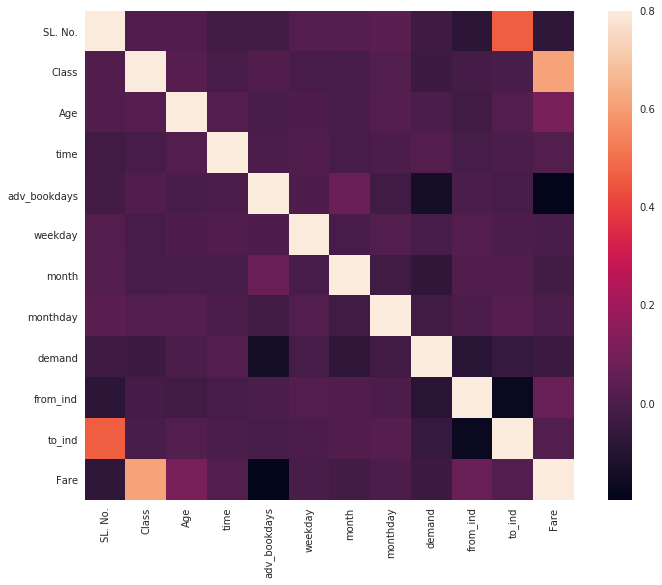

In [53]:
#correlation matrix. Plot the correlation between all indepnedant features
corrmat = Airline_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

STACKING

In [55]:
import mlxtend
print(mlxtend.__version__)

0.17.2


In [56]:
# Another way to get better accuracy from model is a technique called Ensambling. "Getting all of them together"
# In this method all the models are stacked together and then again fitted with Training data and tested on
# Testing data
from mlxtend.regressor import StackingCVRegressor
from sklearn.pipeline import make_pipeline

#setup models
ridge = make_pipeline(RobustScaler(), 
                      RidgeCV(alphas = alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas = alphas2,
                              random_state = 42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(), 
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas, 
                                        cv=kfolds, l1_ratio=e_l1ratio))

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=31,
                              learning_rate=0.1, n_estimators=200,
                              max_bin = 100, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.8,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))


xgboost = make_pipeline(RobustScaler(),
                        XGBRegressor(learning_rate =0.1, n_estimators=200, max_depth=10,
                     min_child_weight=5 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.8,objective= 'reg:squarederror',
                     nthread=4,scale_pos_weight=1,seed=27, reg_alpha=0.00006))

In [57]:
# Stack the the models together for stacked regression
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, 
                                            xgboost, lightgbm), 
                               meta_regressor=xgboost,
                               use_features_in_secondary=True)

In [58]:
#prepare dataframes for stacked models
stackX = np.array(X_train)
print(stackX.shape)
stacky = np.array(y_train)
print(stacky.shape)


(3499, 11)
(3499,)


In [59]:
# Fit the stacked model
stack_gen_model = stack_gen.fit(stackX, stacky)

In [60]:
# Predict on individual models and stacked model
em_preds = elastic_model3.predict(X_test)
lasso_preds = lasso_model2.predict(X_test)
ridge_preds = ridge_model2.predict(X_test)
stack_gen_preds = stack_gen_model.predict(X_test)
xgb_preds = xgb_fit.predict(X_test)
#svr_preds = svr_fit.predict(X_test)
lgbm_preds = lgbm_fit.predict(X_test)


In [61]:
# Find the accuracy measure on Stacked model
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse = np.sqrt(mean_squared_error(y_test, stack_gen_preds))
print("RMSE: %f" % (rmse))

RMSE: 2820.223340


In [62]:
#In order to compare the accuracy of best in class model ( Extra gradient boost - XGB) and ensembled model
# predict the fares for both model. First XGB and store the results in CSV file
df_test_xgb = df_test[['SL. No.','Class', 'Age', 'time', 'adv_bookdays', 'weekday', 'month','monthday',
       'demand', 'from_ind', 'to_ind']]
preds_1 = xgb_fit.predict(df_test_xgb)
df_test_xgb['Fare'] = preds_1
df_test_xgb.to_csv('flight_price_5.csv')

In [ ]:
# Then stacked or ensembled model and store it in a different CSV file.
df_test_xgb = df_test[['SL. No.','Class', 'Age', 'time', 'adv_bookdays', 'weekday', 'month','monthday',
       'demand', 'from_ind', 'to_ind']]
preds_1 = stack_gen_model.predict(df_test_xgb)
df_test_xgb['Fare'] = preds_1
df_test_xgb.to_csv('flight_price_10.csv')